**Pricing options and computing implied volatilities
using neural networks**

## Option Pricing using Heston Method

In [1]:
!pip -q install colorama
!pip -q install pyDOE

In [2]:
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from pyDOE import lhs
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from colorama import Fore, Style

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore", category=UserWarning, message=".*target size.*different to the input size.*")

*Table 2. The Selected Model After the Random Search*

<div>
    <style>
        table {
            border-collapse: collapse;
            width: 50%;
            margin: 20px auto;
            font-family: Arial, sans-serif;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
    <table>
        <thead>
            <tr>
                <th>Parameter</th>
                <th>Option</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Hidden layers</td>
                <td>4</td>
            </tr>
            <tr>
                <td>Neurons (each layer)</td>
                <td>400</td>
            </tr>
            <tr>
                <td>Activation</td>
                <td>ReLU</td>
            </tr>
            <tr>
                <td>Dropout rate</td>
                <td>0.0</td>
            </tr>
            <tr>
                <td>Batch-normalization</td>
                <td>No</td>
            </tr>
            <tr>
                <td>Initialization</td>
                <td>Glorot_uniform</td>
            </tr>
            <tr>
                <td>Optimizer</td>
                <td>Adam</td>
            </tr>
            <tr>
                <td>Batch size</td>
                <td>1024</td>
            </tr>
        </tbody>
    </table>
</div>

In [4]:
class ANN_Heston(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANN_Heston, self).__init__()

        ''' Define layers '''
        self.fc1 = nn.Linear(input_size, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 400)
        self.fc4 = nn.Linear(400, 400)
        self.fc5 = nn.Linear(400, 1)

        ''' Activation and dropout '''
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.0)

        ''' Apply Glorot (Xavier) initialization to the weights '''
        self._initialize_weights()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

    def _initialize_weights(self):
        ''' Apply Glorot (Xavier) initialization to all layers '''
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        init.xavier_uniform_(self.fc3.weight)
        init.xavier_uniform_(self.fc4.weight)
        init.xavier_uniform_(self.fc5.weight)

Data Generation

In [5]:
torch.manual_seed(42)
np.random.seed(42)

In [6]:
batch_size = 10
num_samples = 1000

In [28]:
def heston_price(m, v0, kappa, theta, sigma, rho, tau, r, a, b, N_cos):
    sum=0
    sum1=0
    moneyness = m - r* tau
    for k in range(0, N_cos):
      args = (m, v0, kappa, theta, sigma, rho, tau, r, a, b)
      res= heston_charfunc(k* np.pi/(b-a), *args)* U_k_calc(k, a, b)* np.exp(-1j* k* np.pi* ((moneyness+ a)/(b-a)))
      if k==0 :
        sum1=res
      else:
        sum+=res
    result= np.exp(-r* tau)* np.real(0.5* sum1+ sum)
    return result

def heston_charfunc(w, m, v0, kappa, theta, sigma, rho, tau, r, a, b):

    args = (w, m, v0, kappa, theta, sigma, rho, tau, r, a, b)
    D= D_calc(*args)
    G= G_calc(*args)
    result= np.exp(1j* w* r* tau+ (v0/(sigma**2))* ((1- np.exp(-1* D* tau))/(1-G* np.exp(-1* D* tau)))
    * (kappa- (1j* rho* sigma* w)- D))* np.exp((kappa* theta/ (sigma**2))* (tau* (kappa- 1j* rho* sigma* w- D)-
                                                                                   2* np.log((1- G* np.exp(-1* D* tau))/(1-G))))

    return result

def D_calc(w, m, v0, kappa, theta, sigma, rho, tau, r, a, b):

    result= np.sqrt((kappa- 1j* rho* sigma* w)**2 + (w**2+ 1j* w)* (sigma**2))

    return result

def G_calc(w, m, v0, kappa, theta, sigma, rho, tau, r, a, b):

    args = (w, m, v0, kappa, theta, sigma, rho, tau, r, a, b)
    D= D_calc(*args)
    result= (kappa- 1j* rho* sigma* w- D )/ (kappa- 1j* rho* sigma* w+ D)

    return result

def U_k_calc(k, a, b):

    result= (2/(b-a))* (Chi_k(k, 0, b, a, b)- Psi_k(k, 0, b, a, b))

    return result

def Chi_k(k, c, d, a, b):

    result= (1/((1+ (k* np.pi/ (b-a))**2) ))* ((np.cos(k* np.pi * ((d-a)/(b-a)))* np.exp(d))- (np.cos(k* np.pi* ((c-a)/(b-a)))* np.exp(c))
    + ((k* np.pi/(b-a)) *np.sin(k* np.pi* ((d-a)/(b-a)))* np.exp(d))- ((k* np.pi/(b-a)) *np.sin(k* np.pi* ((c-a)/(b-a)))* np.exp(c) ))

    return result

def Psi_k(k, c, d, a, b):

    if k==0:
      result= d-c
    else:
      result=(np.sin(k* np.pi* ((d-a)/(b-a)))- np.sin(k* np.pi* ((c-a)/(b-a))))* (b-a)/ (k* np.pi)
    return result

def calc_a_b(m, v0, kappa, theta, sigma, rho, tau, r, L_cos):

    c1= r* tau+ (1- np.exp(-1* kappa* tau))* ((theta- v0)/ (2* kappa))- 0.5* theta* tau

    c2= (1/(8* (kappa**3)))* (sigma* tau* kappa* np.exp(-1* kappa* tau)*(v0-theta)* (8* kappa* rho- 4* sigma)+
                            kappa* rho* sigma* (1- np.exp(-1* kappa* tau))* (16* theta- 8* v0)+
                            2* theta* kappa* tau* (-4* kappa* rho* sigma+ sigma**2+ 4* (kappa**2))+
                            sigma**2 * ((theta- 2*v0)* np.exp(-2* kappa* tau)+ theta* (6* np.exp(-1* kappa* tau)-7)+ 2* v0)+
                            8* (kappa**2) * (v0- theta)* (1-np.exp(-1* kappa * tau)))

    a= c1- L_cos* (np.sqrt(np.abs(c2)))
    b= c1+ L_cos* (np.sqrt(np.abs(c2)))

    return a, b

def lhs_sample(range_values):
    lower_bound, upper_bound = range_values
    samples = lhs(1, samples=1)
    scaled_sample = samples * (upper_bound - lower_bound) + lower_bound
    return scaled_sample.item()

dataset = []
for i in range(num_samples):
    m = lhs_sample([0.6, 1.4])
    tau = lhs_sample([0.1, 1.4])
    r = lhs_sample([0.0, 0.1])
    rho = lhs_sample([-0.95, 0.0])
    kappa = lhs_sample([0.0, 2.0])
    theta = lhs_sample([0.0, 0.5])
    sigma = lhs_sample([0.0, 0.5])
    v0 = lhs_sample([0.05, 0.5])

    a, b = calc_a_b(np.log(m), v0, kappa, theta, sigma, rho, tau, r, L_cos=50)
    option_price = heston_price(np.log(m), v0, kappa, theta, sigma, rho, tau, r, a, b, N_cos=1500)
    dataset.append([m, tau, r, rho, kappa, theta, sigma, v0, option_price])
df = pd.DataFrame(dataset, columns=['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'v0', 'option_price'])
df = df.fillna(df.mean())
df = df.replace([np.inf, -np.inf], np.nan).fillna(df.mean())
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

<ipython-input-28-6924bbd3538a>:48: RuntimeWarning: overflow encountered in exp
  result= (1/((1+ (k* np.pi/ (b-a))**2) ))* ((np.cos(k* np.pi * ((d-a)/(b-a)))* np.exp(d))- (np.cos(k* np.pi* ((c-a)/(b-a)))* np.exp(c))
<ipython-input-28-6924bbd3538a>:49: RuntimeWarning: overflow encountered in exp
  + ((k* np.pi/(b-a)) *np.sin(k* np.pi* ((d-a)/(b-a)))* np.exp(d))- ((k* np.pi/(b-a)) *np.sin(k* np.pi* ((c-a)/(b-a)))* np.exp(c) ))
<ipython-input-28-6924bbd3538a>:49: RuntimeWarning: invalid value encountered in scalar multiply
  + ((k* np.pi/(b-a)) *np.sin(k* np.pi* ((d-a)/(b-a)))* np.exp(d))- ((k* np.pi/(b-a)) *np.sin(k* np.pi* ((c-a)/(b-a)))* np.exp(c) ))
<ipython-input-28-6924bbd3538a>:48: RuntimeWarning: invalid value encountered in scalar add
  result= (1/((1+ (k* np.pi/ (b-a))**2) ))* ((np.cos(k* np.pi * ((d-a)/(b-a)))* np.exp(d))- (np.cos(k* np.pi* ((c-a)/(b-a)))* np.exp(c))
<ipython-input-28-6924bbd3538a>:7: RuntimeWarning: invalid value encountered in scalar multiply
  res= heston_c

In [38]:
max_value = df['option_price'].values.max()
print("Maximum value in the entire DataFrame:", max_value)

Maximum value in the entire DataFrame: 8.214623343626281e+213


In [29]:
scaler = MinMaxScaler()
train_df['option_price'] = scaler.fit_transform(train_df['option_price'].values.reshape(-1, 1))
test_df['option_price'] = scaler.transform(test_df['option_price'].values.reshape(-1, 1))

In [30]:
X_train = train_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'v0']].values
y_train = train_df['option_price'].values
X_test = test_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'v0']].values
y_test = test_df['option_price'].values

''' Convert to PyTorch tensors '''
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

''' Create TensorDataset '''
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

''' Create DataLoader '''
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
def train(model, train_loader, criterion, optimizer, num_epochs, scaler):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        all_targets_scaled = []
        all_predictions_scaled = []

        ''' Create a progress bar for the current epoch '''
        pbar = tqdm(
            train_loader,
            desc=f"{Fore.GREEN}Epoch {epoch + 1}/{num_epochs}{Style.RESET_ALL}",
            ncols=100,
            dynamic_ncols=True,
            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]",
        )

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output = model(data)
            target = target.view_as(output)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            ''' Collect scaled predictions and targets for metrics calculation '''
            all_predictions_scaled.extend(output.detach().cpu().numpy())
            all_targets_scaled.extend(target.detach().cpu().numpy())

            ''' Update the progress bar with batch loss '''
            pbar.set_postfix({
                f"{Fore.YELLOW}Batch Loss{Style.RESET_ALL}": f"{loss.item():.6f}"
            })

        ''' Reshape before inverse transform '''
        all_predictions_scaled = np.array(all_predictions_scaled).reshape(-1, 1)
        all_targets_scaled = np.array(all_targets_scaled).reshape(-1, 1)

        ''' Reverse transform predictions and targets to original scale '''
        all_predictions = scaler.inverse_transform(all_predictions_scaled).flatten()
        all_targets = scaler.inverse_transform(all_targets_scaled).flatten()

        all_predictions = np.clip(all_predictions, 0, 1000)
        all_targets = np.clip(all_targets, 0, 1000)

        ''' Calculate metrics for the epoch '''
        mse = mean_squared_error(all_targets, all_predictions)
        mae = mean_absolute_error(all_targets, all_predictions)
        avg_loss = epoch_loss / len(train_loader)

        train_losses.append(avg_loss)
        print(
            f"{Fore.CYAN}Results :{Style.RESET_ALL} "
            f"{Fore.MAGENTA}Average Loss:{Style.RESET_ALL} {avg_loss:.6f}, "
            f"{Fore.MAGENTA}MSE:{Style.RESET_ALL} {mse:.6f}, "
            f"{Fore.MAGENTA}MAE:{Style.RESET_ALL} {mae:.6f}\n"
        )

    return train_losses

In [32]:
def test(model, test_loader, scaler):
    model.eval()
    test_loss = 0
    y_pred_scaled = []
    y_true_scaled = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            y_pred_scaled.extend(output.cpu().numpy())
            y_true_scaled.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).flatten()
    y_true = scaler.inverse_transform(np.array(y_true_scaled).reshape(-1, 1)).flatten()

    ''' Calculate metrics on original scale '''
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mse, mae, r2


In [33]:
def plot_loss_history(history):
    epochs = range(1, len(history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history, label="Training Loss", color='b', marker='o', linestyle='-', markersize=6)

    plt.title("Training Loss Over Epochs", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)

    plt.grid(True)
    plt.legend(loc='upper right')

    plt.show()

In [34]:
model = ANN_Heston(input_size=8, num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.019928, MSE: 454444.437500, MAE: 454.444458



Epoch 2/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001660, MSE: 482222.218750, MAE: 482.222229



Epoch 3/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001932, MSE: 488888.875000, MAE: 488.888885



Epoch 4/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001661, MSE: 485555.562500, MAE: 485.555542



Epoch 5/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001632, MSE: 481111.125000, MAE: 481.111115



Epoch 6/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001878, MSE: 497777.781250, MAE: 497.777771



Epoch 7/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001528, MSE: 498888.875000, MAE: 498.888885



Epoch 8/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001394, MSE: 497777.781250, MAE: 497.777771



Epoch 9/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001711, MSE: 481111.125000, MAE: 481.111115



Epoch 10/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001419, MSE: 491111.125000, MAE: 491.111115



Epoch 11/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001191, MSE: 513333.343750, MAE: 513.333313



Epoch 12/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001450, MSE: 498888.875000, MAE: 498.888885



Epoch 13/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001210, MSE: 510000.000000, MAE: 510.000000



Epoch 14/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001234, MSE: 497777.781250, MAE: 497.777771



Epoch 15/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.000929, MSE: 506666.656250, MAE: 506.666656



Epoch 16/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001133, MSE: 514444.437500, MAE: 514.444458



Epoch 17/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001097, MSE: 496666.656250, MAE: 496.666656



Epoch 18/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001053, MSE: 475555.562500, MAE: 475.555542



Epoch 19/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.001307, MSE: 493333.343750, MAE: 493.333344



Epoch 20/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.000889, MSE: 494444.437500, MAE: 494.444458



Epoch 21/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.000910, MSE: 508888.875000, MAE: 508.888885



Epoch 22/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.000732, MSE: 496666.656250, MAE: 496.666656



Epoch 23/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.000917, MSE: 491111.125000, MAE: 491.111115



Epoch 24/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.000548, MSE: 496666.656250, MAE: 496.666656



Epoch 25/25: 100%|██████████| 90/90 [00:00<00:00]
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


Results : Average Loss: 0.000563, MSE: 491111.125000, MAE: 491.111115



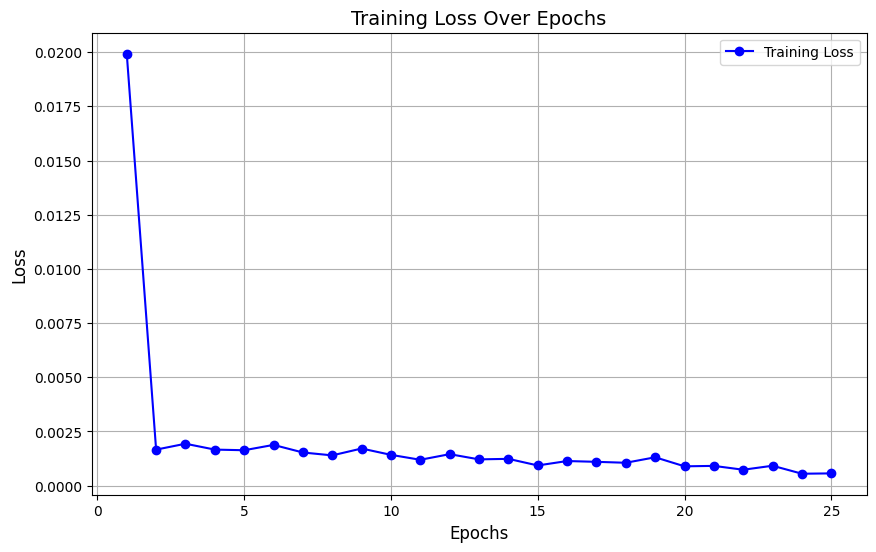

In [35]:
history = train(model, train_loader, criterion, optimizer, 25, scaler)
plot_loss_history(history)

Eveluation on Test Data

In [18]:
mse, mae, r2 = test(model, test_loader,scaler)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:575: RuntimeWarning: overflow encountered in divide
  X /= self.scale_
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains infinity or a value too large for dtype('float32').

Eveluation on Train Data

In [ ]:
mse, mae, r2 = test(model, train_loader,scaler)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

In [ ]:
''' Reverse the scalled data '''
train_df['option_price'] = scaler.inverse_transform(train_df['option_price'].values.reshape(-1, 1))
test_df['option_price'] = scaler.inverse_transform(test_df['option_price'].values.reshape(-1, 1))

## Implied Volatility using Heston Method

In [ ]:
scaler1 = MinMaxScaler()
train_df['v0'] = scaler1.fit_transform(train_df['v0'].values.reshape(-1, 1))
test_df['v0'] = scaler1.transform(test_df['v0'].values.reshape(-1, 1))

In [ ]:
X_train = train_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'option_price']].values
y_train = train_df['v0'].values

X_test = test_df[['m', 'tau', 'r', 'rho', 'kappa', 'theta', 'sigma', 'option_price']].values
y_test = test_df['v0'].values

''' Convert to PyTorch tensors '''
X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train, dtype=torch.float64)

X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test, dtype=torch.float64)

''' Create TensorDataset '''
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

''' Create Train loader and Test Loader '''
train_loader1 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader1 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model_implied = ANN_Heston(input_size=8, num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_implied.parameters(), lr=0.0001)

In [ ]:
history = train(model_implied, train_loader1, criterion, optimizer, 25, scaler1)
plot_loss_history(history)

Eveluation on Test Data

In [ ]:
mse, mae, r2 = test(model_implied, test_loader1,scaler1)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')

Eveluation on Training Data

In [ ]:
mse, mae, r2 = test(model_implied, train_loader1,scaler1)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R² Score: {r2:.4f}')